In [ ]:
import pandas as pd
import numpy as np

file_path = 'dataset1.xlsx'

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float64)  # Ensure consistent dtype as float64
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k).astype(np.float64),  # Convert to float64
            f"cos_{freq}_{i}": np.cos(i * k).astype(np.float64),  # Convert to float64
        })
    return pd.DataFrame(features, index=index)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

df = pd.read_excel(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df['time'] = pd.to_datetime(df['time'])
df.describe()

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
count,60600,60312.000000,60312.000000,60312.000000,21564.000000,59997.000000,60312.000000,60304.000000,57610.000000
mean,2021-06-16 11:30:00,17.633159,13.562578,79.481413,0.039575,185.982799,9.129046,1016.967115,2.889932
min,2018-01-01 00:00:00,0.000000,-6.500000,5.000000,0.000000,0.000000,0.000000,995.000000,0.000000
25%,2019-09-24 05:45:00,14.000000,10.100000,68.000000,0.000000,50.000000,5.400000,1014.000000,2.000000
50%,2021-06-16 11:30:00,18.000000,13.900000,83.000000,0.000000,210.000000,9.000000,1016.300000,2.000000
75%,2023-03-09 17:15:00,22.000000,17.000000,94.000000,0.000000,310.000000,13.000000,1020.000000,3.000000
max,2024-11-29 23:00:00,46.000000,24.300000,100.000000,15.400000,360.000000,66.600000,1035.200000,27.000000
std,NaN,5.539292,4.555641,17.083255,0.350016,127.337423,7.160825,4.946310,2.403199


# **Preperation**

In [ ]:
df.drop('coco', axis=1, inplace=True)

In [ ]:
# assuming when the precipitation is not recorded it is 0
df['prcp'] = df['prcp'].fillna(0)

In [ ]:
df.fillna(df.mean(), inplace=True)

# **Exploring data prcp**

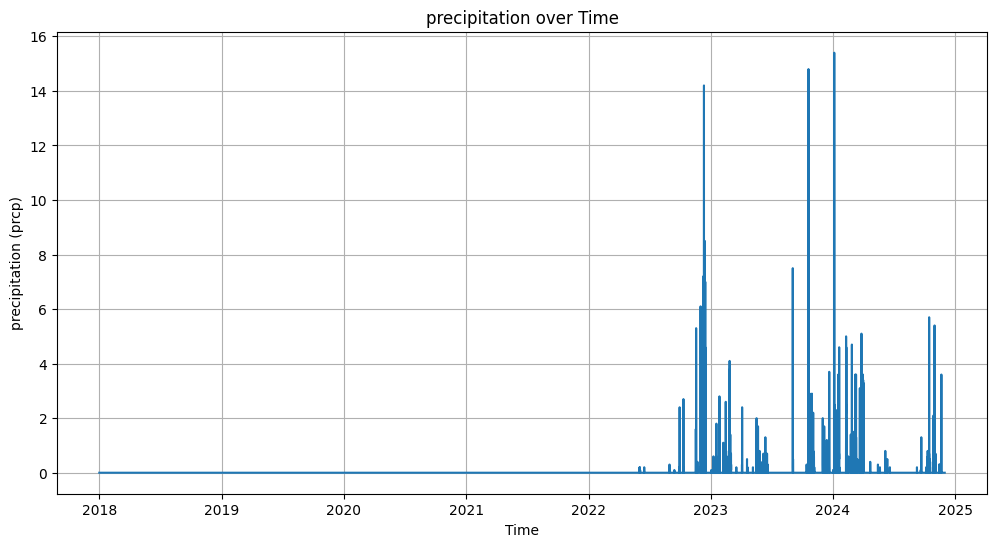

In [ ]:
# prompt: plot prcp over time

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['prcp'])
plt.xlabel('Time')
plt.ylabel('precipitation (prcp)')
plt.title('precipitation over Time')
plt.grid(True)
plt.show()


**data of prcp before 2022 wasn't recorded**

In [ ]:
# prompt: drop all data wich time is less than 2022

# Assuming 'time' column is already in datetime format as shown in the provided code.
df = df[df['time'].dt.year >= 2022]

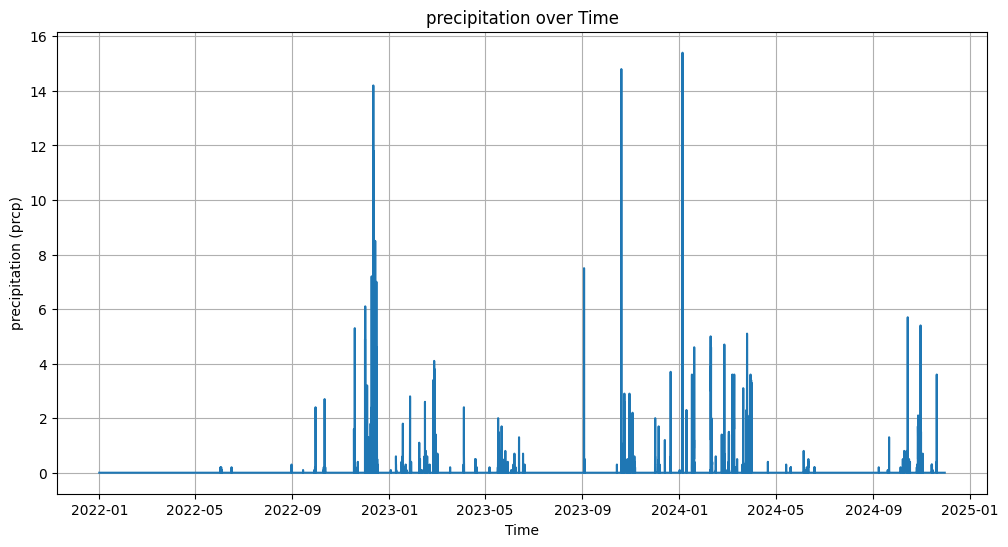

In [ ]:
# prompt: plot prcp over time

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['prcp'])
plt.xlabel('Time')
plt.ylabel('precipitation (prcp)')
plt.title('precipitation over Time')
plt.grid(True)
plt.show()


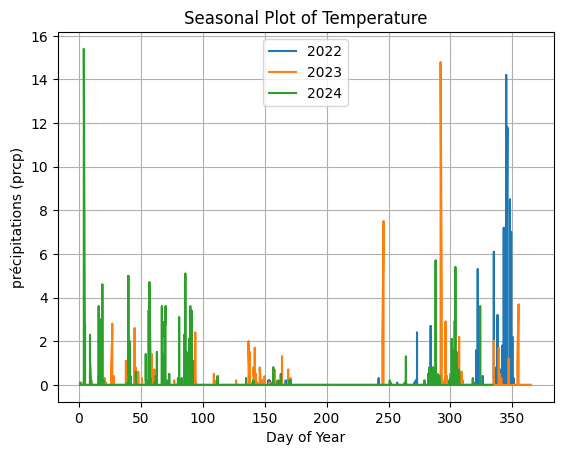

In [ ]:
import matplotlib.pyplot as plt

# Group the data by year
years = df['time'].dt.year.unique()
for year in years:
  df_year = df[df['time'].dt.year == year]
  plt.plot(df_year['time'].dt.dayofyear, df_year['prcp'], label=str(year))

plt.xlabel('Day of Year')
plt.ylabel('précipitations (prcp)')
plt.title('Seasonal Plot of Temperature')
plt.grid(True)
plt.legend()
plt.show()


**We can notice the seasonality a peak between the end and start of year but I need to gather more data TODO**

In [ ]:
# adding fourier features
# yearly
freq = 365 * 24
order = 2
seasonal_features = fourier_features(df.index, freq, order)
df = pd.concat([df, seasonal_features], axis=1)
df.tail()

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,sin_8760_1,cos_8760_1,sin_8760_2,cos_8760_2
60595,2024-11-29 19:00:00,19.8,13.3,66.0,0.0,87.0,5.5,1023.9,-0.511755,0.859131,-0.879330,0.476213
60596,2024-11-29 20:00:00,18.4,12.8,70.0,0.0,91.0,3.7,1024.1,-0.511139,0.859498,-0.878646,0.477474
60597,2024-11-29 21:00:00,17.1,12.2,73.0,0.0,98.0,3.7,1024.3,-0.510522,0.859864,-0.877960,0.478734
60598,2024-11-29 22:00:00,15.8,11.8,77.0,0.0,107.0,1.8,1024.5,-0.509905,0.860230,-0.877272,0.479993
60599,2024-11-29 23:00:00,15.3,11.3,77.0,0.0,106.0,1.8,1024.5,-0.509288,0.860596,-0.876583,0.481251


**checking hourly seasonality**

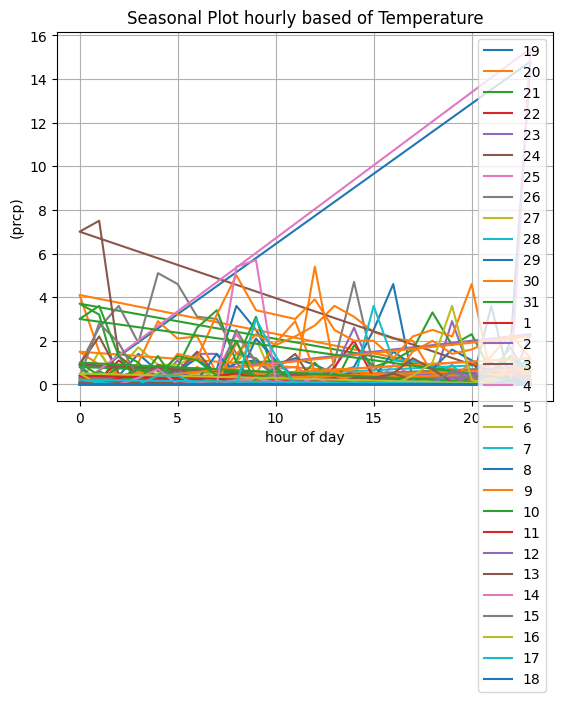

In [ ]:
n = 500
# Select the last n days of data
last_n_days = df.tail(n * 24)  # Assuming hourly data
days = last_n_days['time'].dt.day.unique()
for day in days:
  df_day = last_n_days[last_n_days['time'].dt.day == day]
  plt.plot(df_day['time'].dt.hour, df_day['prcp'], label=str(day))

plt.xlabel('hour of day')
plt.ylabel('(prcp)')
plt.title('Seasonal Plot hourly based of Temperature')
plt.grid(True)
plt.legend()
plt.show()


**No houly seasonality noticed**

# **let's explore serial dependance (cycles)**

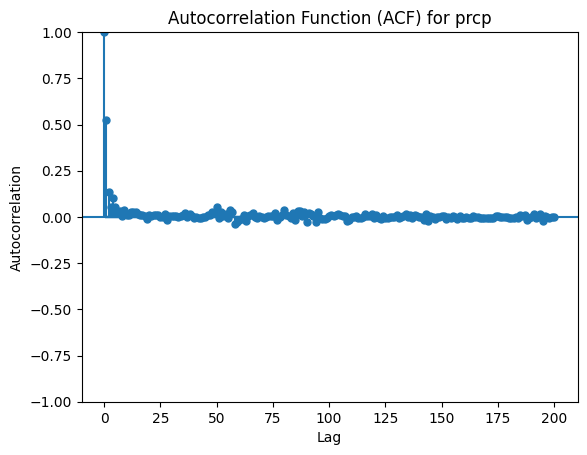

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Assuming 'df' is your DataFrame and 'tavg' is the column of interest
plot_pacf(df['prcp'], lags=200)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) for prcp')
plt.show()

# **aucorrelation with the first 8-10**

In [ ]:
# Add lagged features
for i in range(0, 10):
  df[f'prcp_lag_{i}'] = df['prcp'].shift(i)
df.dropna(inplace=True)

# **Starting the model (last preperation and training)**

In [ ]:
# drop the date and store it in a date variable
date = df['time']
df = df.drop('time', axis=1)
df = df[sorted(df.columns)]

In [ ]:
# Add a new column 'precep_bool' to the dataset
df['precep_bool'] = (df['prcp'] > 0).astype(int)
df.drop('prcp', axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets
train_data, test_data = train_test_split(df, test_size=0.3, shuffle=False)

In [ ]:
# Define the features (X) and target variable (y)
features = [col for col in df.columns if col != 'precep_bool']
X_train = train_data[features]
y_train = train_data['precep_bool']

In [ ]:
# prompt: make a logistic regression model

from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Make predictions on the test set
X_test = test_data[features]
y_test = test_data['precep_bool']
y_pred_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.15
y_pred = (y_pred_proba >= threshold).astype(int)
# Evaluate the model (example: accuracy)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


#Further evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Accuracy: 0.9881185533359447
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7248
           1       0.92      0.86      0.89       411

    accuracy                           0.99      7659
   macro avg       0.95      0.93      0.94      7659
weighted avg       0.99      0.99      0.99      7659

[[7216   32]
 [  59  352]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# My impression: not great results especially for prediction raining (recall of 1) only 71ù of the time it rains it manages to predict it rained, which a bit poor bcause the point of the model is to tell you if it would rain or not false negatives are bad

In [ ]:
y_train_multistep = make_multistep_target(y_train, 24)
y_test_multistep = make_multistep_target(test_data['precep_bool'], 24)


# Drop rows with NaN values in the multi-step target
X_train_multistep = X_train.loc[y_train_multistep.dropna().index]
y_train_multistep = y_train_multistep.dropna()

X_test_multistep = X_test.loc[y_test_multistep.dropna().index]
y_test_multistep = y_test_multistep.dropna()

In [ ]:
from sklearn.multioutput import MultiOutputClassifier

# Train the multi-output logistic regression model
logistic_model_multistep = MultiOutputClassifier(LogisticRegression(max_iter=1000))
logistic_model_multistep.fit(X_train_multistep, y_train_multistep)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Step 1:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7225
           1       0.97      0.71      0.82       411

    accuracy                           0.98      7636
   macro avg       0.98      0.85      0.90      7636
weighted avg       0.98      0.98      0.98      7636

Step 2:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      7225
         1.0       0.88      0.40      0.55       411

    accuracy                           0.97      7636
   macro avg       0.93      0.70      0.77      7636
weighted avg       0.96      0.97      0.96      7636

Step 3:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      7225
         1.0       0.90      0.25      0.39       411

    accuracy                           0.96      7636
   macro avg       0.93      0.62      0.68      7636
weighted avg       0.96      0.96      0.95      7

In [ ]:
# Get probability predictions for each step
multistep_predictions_proba = logistic_model_multistep.predict_proba(X_test_multistep)
threshold = 0.1
# Apply the threshold to convert probabilities to binary predictions
multistep_predictions_binary = np.array([
    (step_proba[:, 1] >= threshold).astype(int) for step_proba in multistep_predictions_proba
]).T  # Transpose to match the expected shape

# Evaluate the predictions for each step
for i in range(24):  # Assuming 24 steps
    print(f"Step {i + 1}:")
    print(classification_report(y_test_multistep[f'y_step_{i + 1}'], multistep_predictions_binary[:, i]))

Step 1:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7225
           1       0.91      0.93      0.92       411

    accuracy                           0.99      7636
   macro avg       0.95      0.96      0.96      7636
weighted avg       0.99      0.99      0.99      7636

Step 2:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      7225
         1.0       0.71      0.68      0.69       411

    accuracy                           0.97      7636
   macro avg       0.84      0.83      0.84      7636
weighted avg       0.97      0.97      0.97      7636

Step 3:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      7225
         1.0       0.61      0.58      0.59       411

    accuracy                           0.96      7636
   macro avg       0.79      0.78      0.79      7636
weighted avg       0.96      0.96      0.96      7

In [ ]:
import pickle

filename = 'trained_model_prcp.sav'
pickle.dump(logistic_model_multistep, open(filename, 'wb'))